# Модуль 9. **Підбір гіперпараметрів НМ**

In [830]:
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import keras

from keras.layers import Dense, Dropout
from keras.models import Sequential

from keras import optimizers
from keras import losses
from keras import metrics
import copy

In [831]:
# константи кольору
YELLOW = "\033[33m"
LIGHTBLUE = "\033[94m"
GRAY_BACK = "\033[100m"
RESET = "\033[0m"

### Завдання

В якості домашнього завдання вам пропонується створити нейронну мережу за допомогою механізмів Keras, яка буде класифікувати товари із датасету _fasion_mnist_ (https://www.tensorflow.org/datasets/catalog/fashion_mnist).

Вам належить запропонувати свою власну архітектуру мережі. Точність найнаївнішої, але адекватної нейромережі становить приблизно 91%. Точність вашої моделі повинна бути не нижчою за цей показник. Щоб досягти таких значень вам знадобиться поекспериментувати з гіперпараметрами мережі:

* кількість шарів;
* кількість нейронів;
* функції активації;
* кількість епох;
* розмір батчу;
* вибір оптимізатора;
* різні техніки регуляризації і т.д.

Використайте вивчені техніки виявлення проблем навчання нейронної мережі, і потім поекспериментуйте.

    Завантаження та аналіз даних

In [832]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0

In [833]:
print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [834]:
# from https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#labels
labels_description = {
    "Label": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "Description": [
        "T-shirt/top",
        "Trouser",
        "Pullover",
        "Dress",
        "Coat",
        "Sandal",
        "Shirt",
        "Sneaker",
        "Bag",
        "Ankle boot",
    ],
}
labels = pd.DataFrame(labels_description)

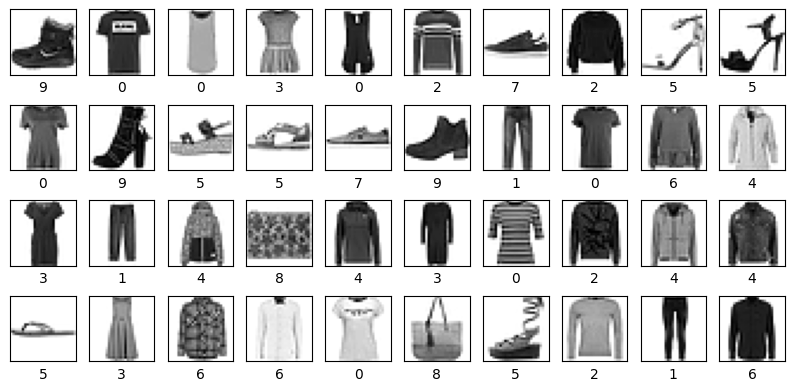

 Label Description
     0 T-shirt/top
     1     Trouser
     2    Pullover
     3       Dress
     4        Coat
     5      Sandal
     6       Shirt
     7     Sneaker
     8         Bag
     9  Ankle boot


In [835]:
plt.figure(figsize=(10, 6))
for i in range(40):
    plt.subplot(5, 10, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])
plt.show() 

print(labels.to_string(index=False))

### Допоміжні функції

    Функція друку поточних параметрів
######      Аргументи: <br>1.  parameters - Поточні параметри для тренування моделі<br>2. text - Заголовок списку параметрів

In [836]:
def print_parameters(parameters: dict, text='Поточні параметри:'):
    print(f"{LIGHTBLUE}{text}{RESET}")
    # print("-" * 18)
    for k, val in parameters.items():
        print(f" {k} \t= {YELLOW}{val}{RESET}")

    Функція відображення графіків історії точності та втрат
######      Аргументи: <br>1. history - дані історії точності та втрат<br>2.  parameters - Поточні параметри тренування моделі

In [837]:
def plt_history(history, parameters):

    dict_data = {
        "accuracy": "Точність на тренувальному наборі",
        "val_accuracy": "Точність на тестовому наборі",
        "loss": "Втрати на тренувальному наборі",
        "val_loss": "Втрати на тестовому наборі",
    }
    epochs = range(1, len(history.history["accuracy"]) + 1)

    color_acc = "royalblue"
    color_loss = "peru"
    linestyle_train = "--"
    linestyle_test = "-"

    print_parameters(parameters)

    for data_, label_ in dict_data.items():
        plt.plot(
            epochs,
            history.history[data_],
            color=color_loss if (data_[-4:] == "loss") else color_acc,
            linestyle=linestyle_test if (data_[:3] == "val") else linestyle_train,
            label=label_,
        )

    # plt.title("Точність та втрати на тренувальному та тестовому наборах")
    plt.xlabel("Епоха")
    plt.ylabel("Метрика")
    plt.legend()
    plt.show()

    Функція підготовки моделі
######      Аргументи: <br>1. model_func - Функція, що містить модель для тренування<br>2. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>3. summary - Параметр для керування виводом даних моделі

In [838]:
def prepare_model(
    model_func,
    hidden_units,
    activation,
    dropout_rate,
    optimizer,
    loss_function,
    metrics,
    summary,
):
    model = model_func(hidden_units, activation, dropout_rate)

    model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)

    if summary:
        model.summary()

    return model

    Функція тренування моделі
######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2. model_func - Функція, що містить модель для тренування<br>3. hidden_units, activation, dropout_rate, optimizer, loss_function, metrics - Параметри для створення моделі<br>4. epochs, batch_size - Параметри для тренування моделі<br>4. verbose, summary - Параметри для керування виводом даних навчання моделі

In [840]:
def train_model(
    train_images,
    train_labels,
    test_images,
    test_labels,
    model_func,
    epochs,
    batch_size,
    dropout_rate,
    loss_function,
    optimizer,
    hidden_units,
    activation,
    metrics,
    verbose=0,
    summary=0,
):

    model = prepare_model(
        model_func,
        hidden_units,
        activation,
        dropout_rate,
        optimizer,
        loss_function,
        metrics,
        summary,
    )

    history = model.fit(
        train_images,
        train_labels,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(test_images, test_labels),
        verbose=verbose,
    )

    print("          Точність:")
    train_loss, train_acc = model.evaluate(train_images, train_labels)
    print("          тренувальні дані: ", YELLOW, train_acc, RESET)

    test_loss, test_acc = model.evaluate(test_images, test_labels)
    print("          тестові дані:     ", YELLOW, test_acc, RESET)

    return history, test_acc

      Функція пошуку оптимальних параметрів

######      Аргументи: <br>1.  train_images, train_labels, test_images, test_labels - Набори даних для навчання і валідації<br>2.  parameters - Параметри для тренування моделі<br>3.  optimal_parameters - Оптимальні параметри. Спочатку "зі стелі", під час аналізу змінюються на оптимальні<br>4.  study_sequence - Послідовність параметрів, що мають перевірятися<br>5. model_func - Функція, що містить модель для тренування

In [841]:
def find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_func,
    verbose=0,
):

    best_accuracy = 0.0
    best_parameters = {}

    for param in study_sequence:

        print(f"{GRAY_BACK}{"=" * 50}{RESET}")
        print(f"Пошук оптимального значення параметра: {YELLOW}{param} {RESET}")
        print(f"{GRAY_BACK}{"=" * 50}{RESET}")

        param_values = parameters[param]
        best_value = optimal_parameters[param]

        for value in param_values:
            optimal_parameters[param] = value

            print("-" * 50)
            print(f"Тестується значення: {YELLOW}{param} = {value}{RESET}")
            print("-" * 50)

            history, test_acc = train_model(
                train_images,
                train_labels,
                test_images,
                test_labels,
                model_func,
                verbose=verbose,
                **optimal_parameters,
            )

            if test_acc > best_accuracy:
                best_accuracy = test_acc
                best_parameters = copy.deepcopy(optimal_parameters)
                best_value = value

            # Plotting training history
            plt_history(history, optimal_parameters)

        # Update optimal parameter for the current parameter
        optimal_parameters[param] = best_value

        print(
            f"{LIGHTBLUE} Оптимальне значення параметра {YELLOW}{param} = {best_value}"
        )
        print(f"{LIGHTBLUE}   точність на тестових даних: {YELLOW}{best_accuracy}{RESET}", end='\n\n')

    return best_parameters, best_accuracy

    Параметри для тренування моделей

In [842]:
# Оптимальні параметри.
# Спочатку "зі стелі", під час навчання змінюються на справді оптимальні.
optimal_parameters = {
    "epochs": 10,
    "batch_size": 8,
    "dropout_rate": 0.2,
    "loss_function": "sparse_categorical_crossentropy",
    "optimizer": "adam",
    "hidden_units": 128,
    "activation": "relu",
    "metrics": ["accuracy"],
}

# Списки параметрів, що мають бути досліджені
parameters = {
    "epochs": [20, 50, 100],
    # "epochs": [10, 20, 50, 100],

    # "batch_size": [8, 16, 32],
    "batch_size": [8, 32, 64, 128, 256],

    "dropout_rate": [0.1, 0.2],
    # "dropout_rate": [0.0, 0.1, 0.2, 0.3],

    "loss_function": [
        "sparse_categorical_crossentropy",
        # "binary_crossentropy",
        # "mean_squared_error",
    ],

    "optimizer": ["adam", "sgd", "rmsprop"],
    # "optimizer": ["adam", "rmsprop", "sgd", "adagrad", "adadelta"],

    "hidden_units": [64, 128, 256, 512],
    # "hidden_units": [32, 64, 128, 256],

    "activation": ["relu", "sigmoid"],
    # "activation": ["relu", "sigmoid", "tanh"],

    "metrics": [
        "accuracy",
    ],
}

***
### **Модель для тренування 1** 
***
     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

In [843]:
# Видає помилку: 
# UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. 
# When using Sequential models, prefer using an `Input(shape)` object 
# as the first layer in the model instead.

# def model_1(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28), name="Input"),
#             layers.Dense(hidden_units, activation=activation, name="Hidden_layer"),
#             layers.Dropout(dropout_rate, name="Dropout_layer"),
#             layers.Dense(10, activation="softmax", name="Output"),
#         ]
#     )

In [844]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_1(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name='Flatten')(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

    Параметри, для навчання моделі 1
###### study_sequence - Послідовність дослідження

In [845]:
study_sequence = [
    "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    "optimizer",
    "activation",
    # "metrics",
    "epochs",
]

    Пошук оптимальних параметрів для вказаної моделі 
###### model_1 - функція що досліджується

Пошук оптимального значення параметра: batch_size 
--------------------------------------------------
Тестується значення: batch_size = 8
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 911us/step - accuracy: 0.9016 - loss: 0.2626
          тренувальні дані:   0.902483344078064 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8747 - loss: 0.3718
          тестові дані:       0.8737000226974487 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 8
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


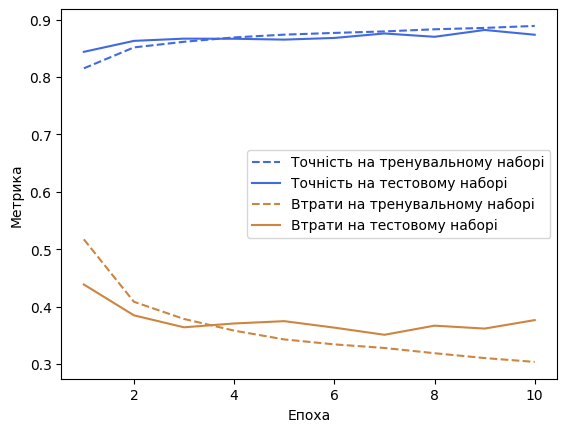

--------------------------------------------------
Тестується значення: batch_size = 32
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 858us/step - accuracy: 0.9089 - loss: 0.2442
          тренувальні дані:   0.9090999960899353 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8803 - loss: 0.3300
          тестові дані:       0.8790000081062317 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 32
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


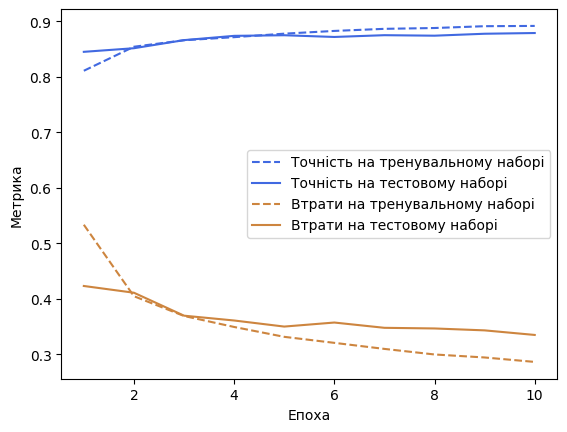

--------------------------------------------------
Тестується значення: batch_size = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 918us/step - accuracy: 0.9092 - loss: 0.2414
          тренувальні дані:   0.9080833196640015 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.8823 - loss: 0.3227
          тестові дані:       0.883400022983551 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


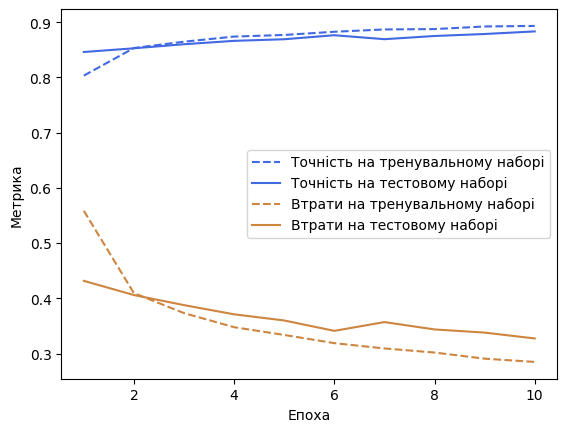

--------------------------------------------------
Тестується значення: batch_size = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.9069 - loss: 0.2494
          тренувальні дані:   0.9060333371162415 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.8811 - loss: 0.3291
          тестові дані:       0.8812000155448914 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 128
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


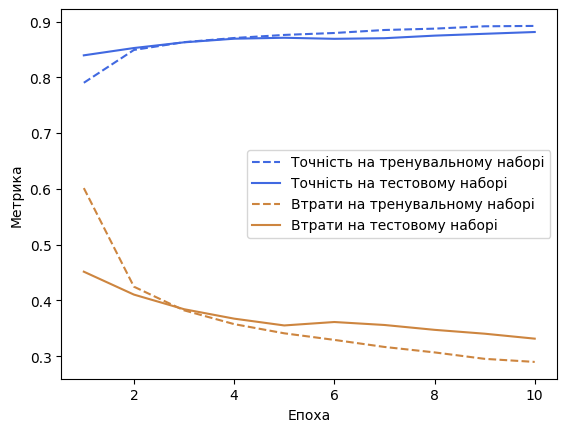

--------------------------------------------------
Тестується значення: batch_size = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 986us/step - accuracy: 0.9046 - loss: 0.2675
          тренувальні дані:   0.9032999873161316 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.8803 - loss: 0.3320
          тестові дані:       0.8788999915122986 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 256
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


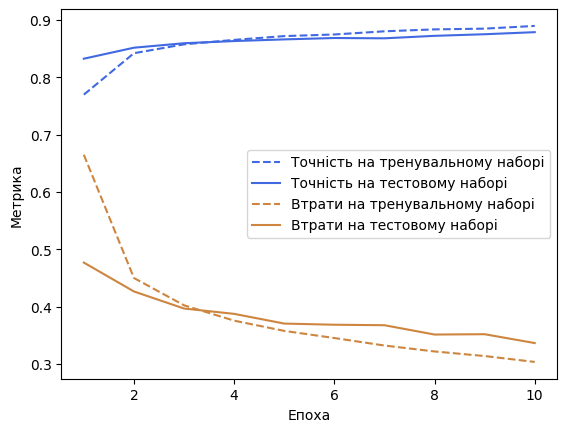

 Оптимальне значення параметра batch_size = 64
   точність на тестових даних: 0.883400022983551

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 873us/step - accuracy: 0.9094 - loss: 0.2424
          тренувальні дані:   0.909250020980835 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.8787 - loss: 0.3378
          тестові дані:       0.8804000020027161 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


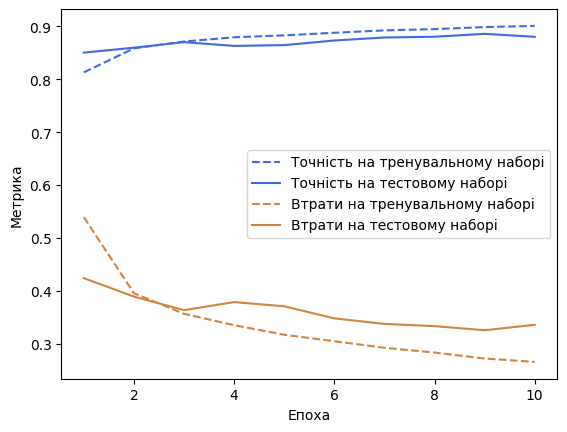

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 900us/step - accuracy: 0.9072 - loss: 0.2501
          тренувальні дані:   0.9059833288192749 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.8788 - loss: 0.3375
          тестові дані:       0.8787999749183655 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


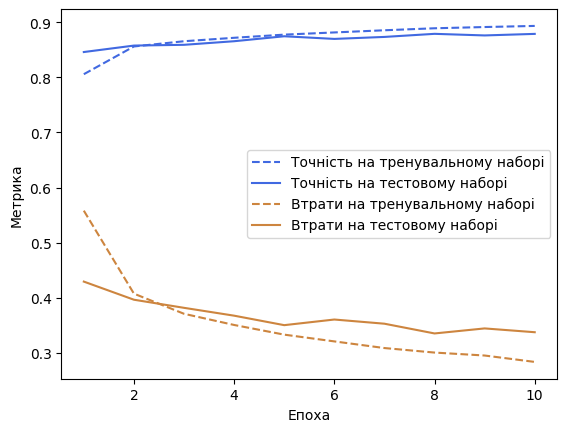

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.883400022983551

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 738us/step - accuracy: 0.8993 - loss: 0.2726
          тренувальні дані:   0.8978833556175232 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8735 - loss: 0.3519
          тестові дані:       0.8737999796867371 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


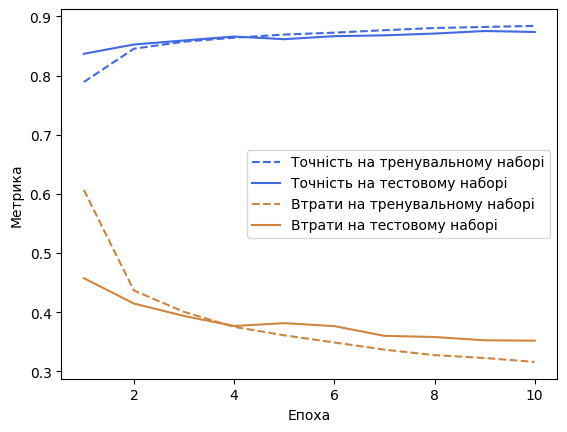

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 925us/step - accuracy: 0.9067 - loss: 0.2483
          тренувальні дані:   0.9069499969482422 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8785 - loss: 0.3287
          тестові дані:       0.8784000277519226 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


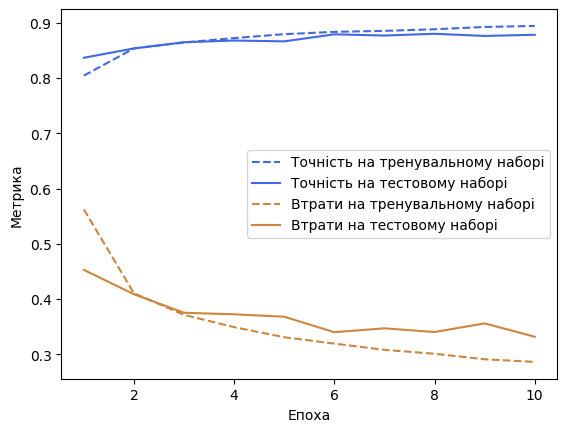

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9160 - loss: 0.2273
          тренувальні дані:   0.9151999950408936 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.8855 - loss: 0.3237
          тестові дані:       0.886900007724762 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


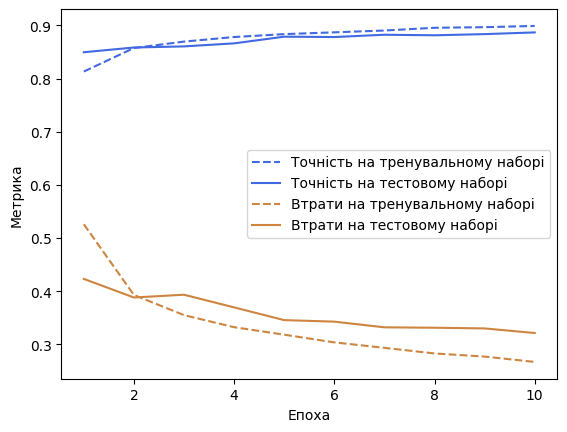

--------------------------------------------------
Тестується значення: hidden_units = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9113 - loss: 0.2324
          тренувальні дані:   0.9107666611671448 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8812 - loss: 0.3292
          тестові дані:       0.8828999996185303 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


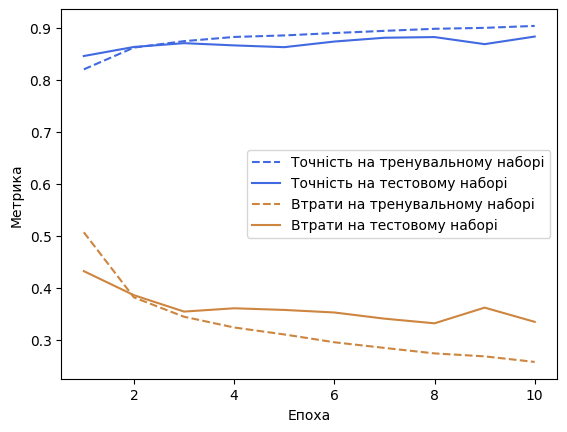

 Оптимальне значення параметра hidden_units = 256
   точність на тестових даних: 0.886900007724762

Пошук оптимального значення параметра: optimizer 
--------------------------------------------------
Тестується значення: optimizer = adam
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8984 - loss: 0.2571
          тренувальні дані:   0.8976500034332275 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8661 - loss: 0.3549
          тестові дані:       0.8675000071525574 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


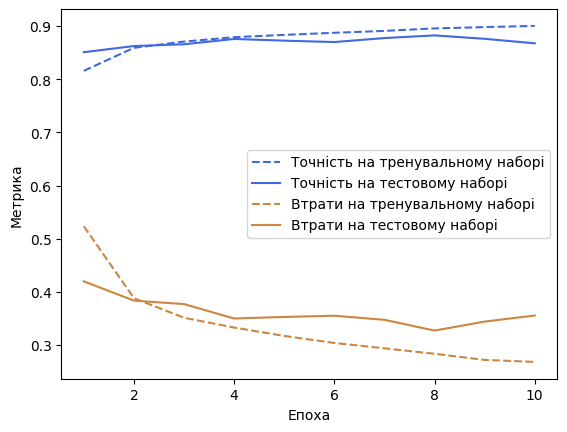

--------------------------------------------------
Тестується значення: optimizer = sgd
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8609 - loss: 0.3996
          тренувальні дані:   0.8602333068847656 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.8504 - loss: 0.4332
          тестові дані:       0.8450000286102295 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= sgd
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


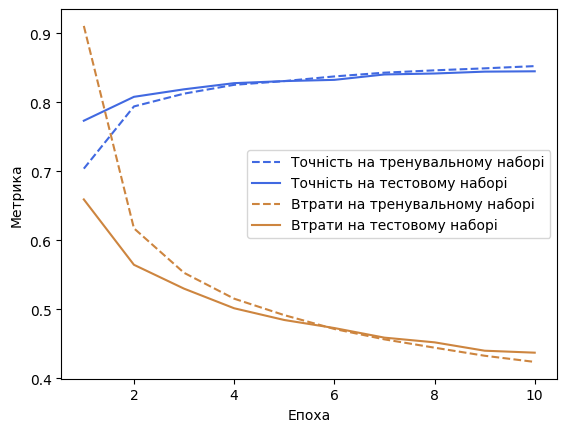

--------------------------------------------------
Тестується значення: optimizer = rmsprop
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9109 - loss: 0.2425
          тренувальні дані:   0.9103999733924866 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8840 - loss: 0.3572
          тестові дані:       0.8835999965667725 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= rmsprop
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


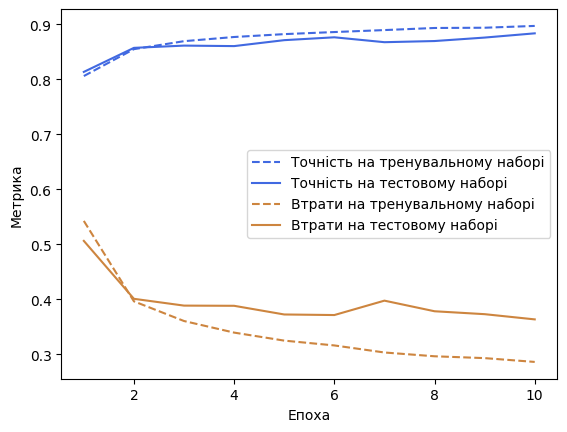

 Оптимальне значення параметра optimizer = adam
   точність на тестових даних: 0.886900007724762

Пошук оптимального значення параметра: activation 
--------------------------------------------------
Тестується значення: activation = relu
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9174 - loss: 0.2227
          тренувальні дані:   0.9158499836921692 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8837 - loss: 0.3188
          тестові дані:       0.8835999965667725 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


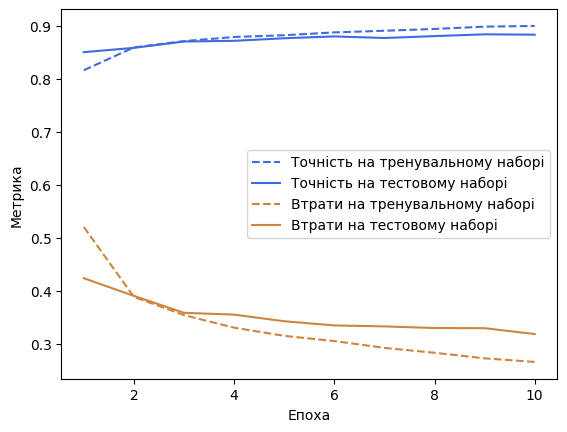

--------------------------------------------------
Тестується значення: activation = sigmoid
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9085 - loss: 0.2531
          тренувальні дані:   0.9077000021934509 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8843 - loss: 0.3299
          тестові дані:       0.8820000290870667 
Поточні параметри:
 epochs 	= 10
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= sigmoid
 metrics 	= ['accuracy']


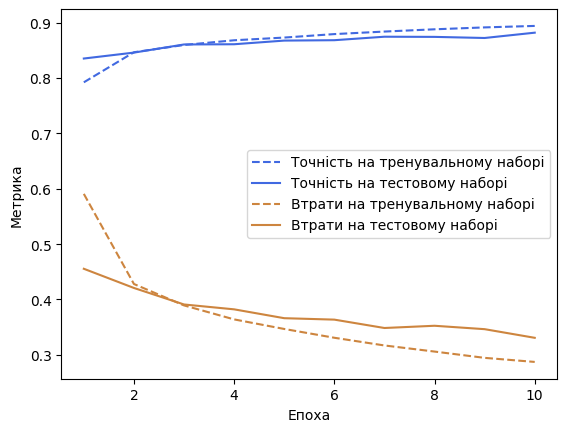

 Оптимальне значення параметра activation = relu
   точність на тестових даних: 0.886900007724762

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9314 - loss: 0.1825
          тренувальні дані:   0.9312166571617126 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8895 - loss: 0.3225
          тестові дані:       0.8906000256538391 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


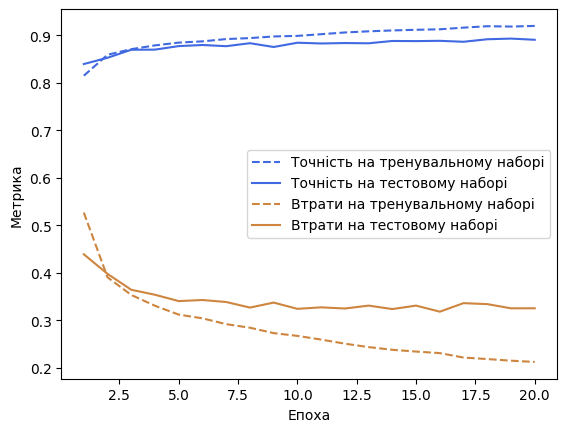

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9592 - loss: 0.1102
          тренувальні дані:   0.9578333497047424 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8907 - loss: 0.4059
          тестові дані:       0.8914999961853027 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


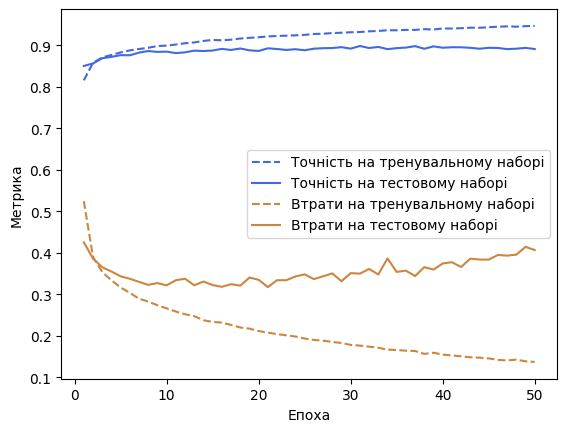

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9802 - loss: 0.0554
          тренувальні дані:   0.9800000190734863 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8960 - loss: 0.5055
          тестові дані:       0.8968999981880188 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


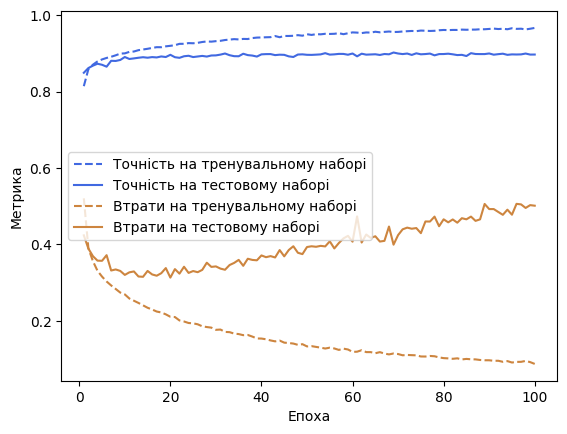

 Оптимальне значення параметра epochs = 100
   точність на тестових даних: 0.8968999981880188



In [846]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_1,
)

In [847]:
print_parameters(best_parameters, "Оптимальні параметри для model_1")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_1
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.8968999981880188


<div class="alert alert-block alert-info">
<b>Висновки model_1:</b> 
<p>Отримано оптимальні параметри для базової моделі з одним прихованим шаром<br>Навіть за оптимізованих параметрів точність моделі (<b>0.8968</b>) недостатня</p>
</div>

In [ ]:
model_1.save("hw_09_model.keras")

***
### **Модель для тренування 2** 
***
_Ускладнимо модель, додавши два додаткових Dense-шари (3 та 4)_

     Шари: 
1. Вхідний шар: Flatten - перетворює вхідні зображення розміром 28x28 у вектор.
2. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць та активаційною функцією, які вказані у параметрах.
3. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 2 рази менше, ніж у шара 2 та активаційною функцією, яка вказані у параметрах.
4. Прихований шар: Повнозв'язний шар (Dense) з кількістю одиниць в 4 рази менше, ніж у шара 2 та активаційною функцією, яка вказані у параметрах.
5. Вихідний шар: Dense з 10 одиницями та активаційною функцією "softmax", яка використовується для класифікації на 10 класів.

_також скоротимо перелік параметрів, що досліджуються до трьох_
1. 'dropout_rate',
2. 'hidden_units',
3. 'epochs'

In [848]:
# def model_2(hidden_units, activation, dropout_rate):
#     return models.Sequential(
#         [
#             layers.Flatten(input_shape=(28, 28)),
#             layers.Dense(hidden_units, activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 2), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(int(hidden_units / 4), activation=activation),
#             layers.Dropout(dropout_rate),
#             layers.Dense(10, activation="softmax"),
#         ]
#     )

In [849]:
# такий варіант помилки не видає, працює так само
# TODO розібратися
def model_2(hidden_units, activation, dropout_rate):
    # # Визначте вхідний шар
    inputs = Input(shape=(28, 28), name="Input")

    # # Додайте шари до моделі
    x = layers.Flatten(name="Flatten")(inputs)
    x = layers.Dense(hidden_units, activation=activation, name="Hidden_layer_1")(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_1")(x)
    x = layers.Dense(
        int(hidden_units / 2), activation=activation, name="Hidden_layer_2"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_2")(x)
    x = layers.Dense(
        int(hidden_units / 4), activation=activation, name="Hidden_layer_3"
    )(x)
    x = layers.Dropout(dropout_rate, name="Dropout_layer_3")(x)
    outputs = layers.Dense(10, activation="softmax", name="Output")(x)

    # # Створіть модель
    model = Model(inputs, outputs)
    return model

In [850]:
study_sequence = [
    # "batch_size",
    "dropout_rate",
    "hidden_units",
    # "loss_function",
    # "optimizer",
    # "activation",
    # "metrics",
    "epochs",
]

Пошук оптимального значення параметра: dropout_rate 
--------------------------------------------------
Тестується значення: dropout_rate = 0.1
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9766 - loss: 0.0607
          тренувальні дані:   0.9766666889190674 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8983 - loss: 0.4620
          тестові дані:       0.8981000185012817 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.1
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


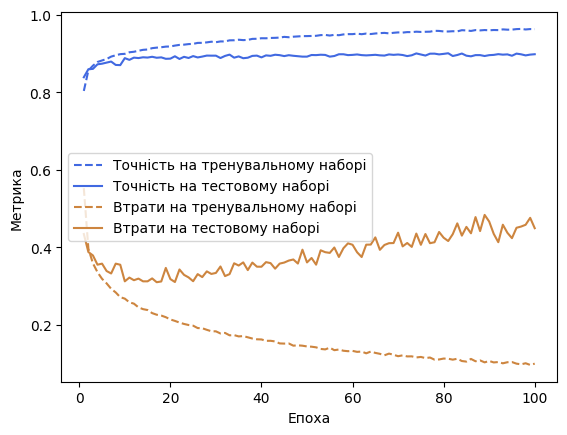

--------------------------------------------------
Тестується значення: dropout_rate = 0.2
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9587 - loss: 0.1099
          тренувальні дані:   0.9581833481788635 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8964 - loss: 0.4152
          тестові дані:       0.8985000252723694 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


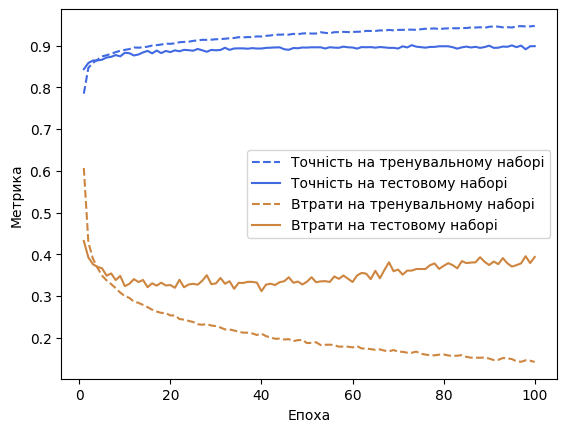

 Оптимальне значення параметра dropout_rate = 0.2
   точність на тестових даних: 0.8985000252723694

Пошук оптимального значення параметра: hidden_units 
--------------------------------------------------
Тестується значення: hidden_units = 64
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 851us/step - accuracy: 0.9240 - loss: 0.2082
          тренувальні дані:   0.9232833385467529 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.8851 - loss: 0.3780
          тестові дані:       0.8835999965667725 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 64
 activation 	= relu
 metrics 	= ['accuracy']


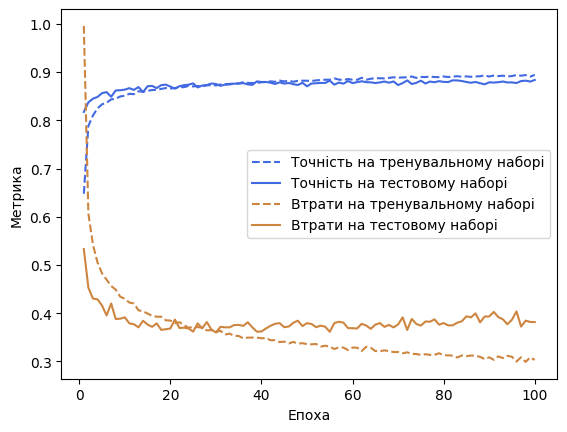

--------------------------------------------------
Тестується значення: hidden_units = 128
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 985us/step - accuracy: 0.9465 - loss: 0.1379
          тренувальні дані:   0.946316659450531 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.8946 - loss: 0.3894
          тестові дані:       0.8914999961853027 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 128
 activation 	= relu
 metrics 	= ['accuracy']


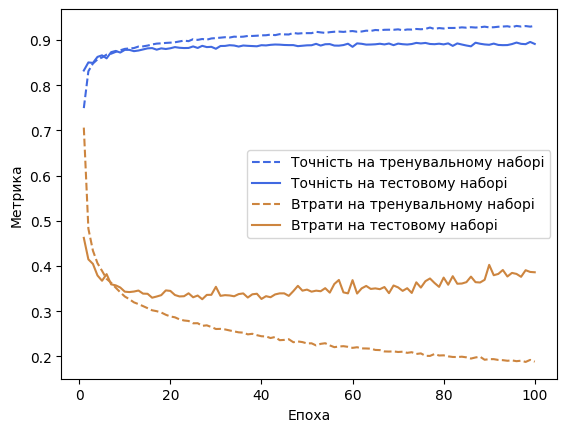

--------------------------------------------------
Тестується значення: hidden_units = 256
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9671 - loss: 0.0906
          тренувальні дані:   0.9673166871070862 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8971 - loss: 0.4027
          тестові дані:       0.8960999846458435 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 256
 activation 	= relu
 metrics 	= ['accuracy']


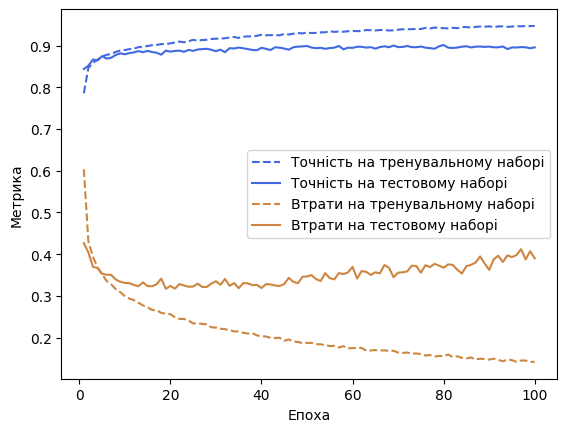

--------------------------------------------------
Тестується значення: hidden_units = 512
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9696 - loss: 0.0852
          тренувальні дані:   0.968500018119812 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9026 - loss: 0.4354
          тестові дані:       0.9027000069618225 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


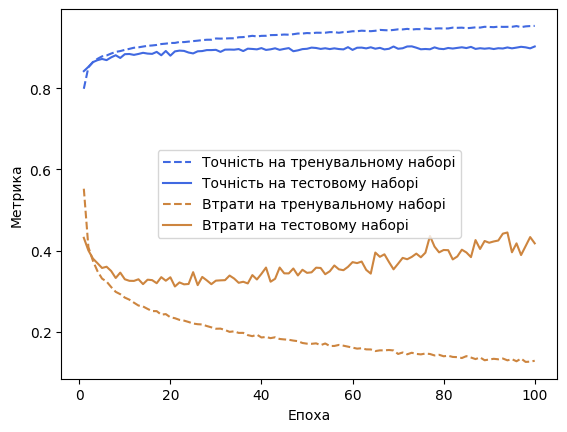

 Оптимальне значення параметра hidden_units = 512
   точність на тестових даних: 0.9027000069618225

Пошук оптимального значення параметра: epochs 
--------------------------------------------------
Тестується значення: epochs = 20
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9226 - loss: 0.2010
          тренувальні дані:   0.9218000173568726 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8836 - loss: 0.3274
          тестові дані:       0.8859999775886536 
Поточні параметри:
 epochs 	= 20
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


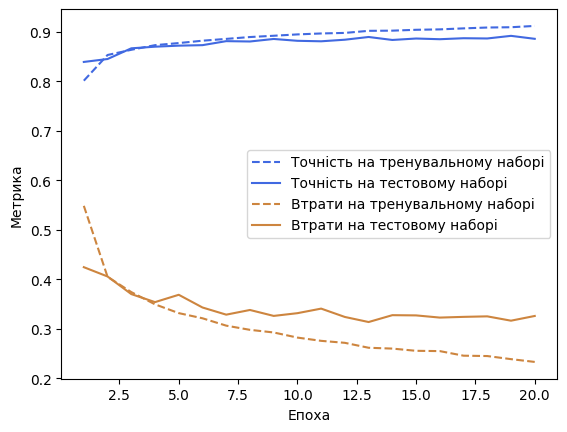

--------------------------------------------------
Тестується значення: epochs = 50
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9506 - loss: 0.1250
          тренувальні дані:   0.9503999948501587 
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8950 - loss: 0.3704
          тестові дані:       0.8981999754905701 
Поточні параметри:
 epochs 	= 50
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


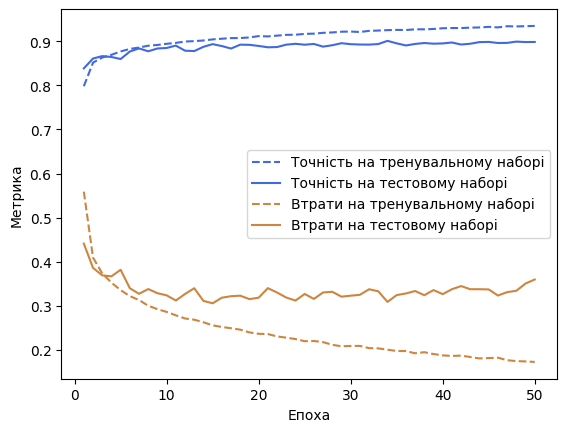

--------------------------------------------------
Тестується значення: epochs = 100
--------------------------------------------------
          Точність:
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9668 - loss: 0.0875
          тренувальні дані:   0.9664999842643738 
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8975 - loss: 0.4296
          тестові дані:       0.8996000289916992 
Поточні параметри:
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']


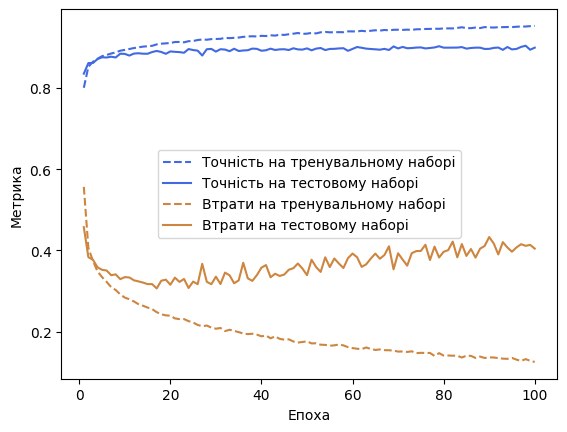

 Оптимальне значення параметра epochs = 100
   точність на тестових даних: 0.9027000069618225



In [851]:
best_parameters, best_accuracy = find_optimal_parameters(
    train_images,
    train_labels,
    test_images,
    test_labels,
    parameters,
    optimal_parameters,
    study_sequence,
    model_2,
)

In [852]:
print_parameters(best_parameters, "Оптимальні параметри для model_2")
print(f" Точність:        {YELLOW}{best_accuracy}")

Оптимальні параметри для model_2
 epochs 	= 100
 batch_size 	= 64
 dropout_rate 	= 0.2
 loss_function 	= sparse_categorical_crossentropy
 optimizer 	= adam
 hidden_units 	= 512
 activation 	= relu
 metrics 	= ['accuracy']
 Точність:        0.9027000069618225


<div class="alert alert-block alert-info">
<b>Висновки model_2:</b> 
<p>Отримано оптимальні параметри для ускладненої моделі з трьома прихованими шарами<br>Спостерігається <b>невеличке покращення</b> роботи моделі після її ускладнення<br>
<b>Точність</b> на тестових даних змінилася з <b>0.8968</b> до <b>0.9027</b></p>
<p>Оптимальні параметри змінилися тільки в одному пункті: <br>
 - hidden_units було 256 стало 512</p>
</div>

In [961]:
model_2.save('hw_09_model.keras')